# Climate data bias correction in the cloud environment
The document demonstrates how to get climate climate model data from online website, then extract data for desired point/points/boundary, implement bias correction, compute several statistics to evaluate bias corrected data, visualize data in different temporal graphs. 

## Importing required python packages
Before proceeding, the some packages have to be installed in your local machine, anaconda environment. Then import the packages as below. 

In [1]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import xarray as xr
import xclim as xc
from xclim import sdba
import xskillscore as xs
import requests

In [2]:
def drkz_search(server="http://esgf-data.dkrz.de/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CORDEX",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

## Getting a climate model data
Now the we defined the function. Use the function to to filter a CMIP6 model. The canadian CanESM2 is selected in this case.

In [3]:
cmip6 = drkz_search(project = 'CMIP6', variable='pr',  source_id = 'HadGEM3-GC31-MM', experiment_id='hist-1950',frequency="day",variant_label = 'r1i1p1f1',nominal_resolution = '100 km')

http://esgf-data.dkrz.de/esg-search/search/?variable=pr&source_id=HadGEM3-GC31-MM&experiment_id=hist-1950&frequency=day&variant_label=r1i1p1f1&nominal_resolution=100 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
http://esgf-data.dkrz.de/esg-search/search/?variable=pr&source_id=HadGEM3-GC31-MM&experiment_id=hist-1950&frequency=day&variant_label=r1i1p1f1&nominal_resolution=100 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
http://esgf-data.dkrz.de/esg-search/search/?variable=pr&source_id=HadGEM3-GC31-MM&experiment_id=hist-1950&frequency=day&variant_label=r1i1p1f1&nominal_resolution=100 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
http://esgf-data.dkrz.de/esg-search/search/?variable=pr&source_id=HadGEM3-GC31-MM&experiment_id=hist-1950&frequency=day&variant_label=r1i1p1f1&nominal_resolution=100 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
h

First we need to see how many files are there and whether data files are right. Then Open the one of the files and explore metadata such as longtitude, latiture, time and other variables of the data. We filtered the latest file as below. 

In [4]:
#Check the first file and last file in the data
cmip6[0], cmip6[len(cmip6[:])-1:], len(cmip6[:])


('http://esgf3.dkrz.de/thredds/dodsC/cmip6/HighResMIP/MOHC/HadGEM3-GC31-MM/hist-1950/r1i1p1f1/day/pr/gn/v20170928/pr_day_HadGEM3-GC31-MM_hist-1950_r1i1p1f1_gn_19500101-19501230.nc',
 ['http://esgf3.dkrz.de/thredds/dodsC/cmip6/HighResMIP/MOHC/HadGEM3-GC31-MM/hist-1950/r1i1p1f1/day/pr/gn/v20170928/pr_day_HadGEM3-GC31-MM_hist-1950_r1i1p1f1_gn_20140101-20141230.nc'],
 65)

As above shows that data starts from 1950 to 2014 and each file has one year of data. So there should be 65 files as shown. Now open the first file data and check metadata which is needed for data extraction later. For example which varaibles are there like lon, lat, precipition (pr), and time. 

In [8]:
#open first data file to see variables
xr.open_dataset(cmip6[0])

<xarray.DataArray 'time' (time: 12240)>
array([cftime.Datetime360Day(1981, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1981, 1, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1981, 1, 3, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.Datetime360Day(2014, 12, 28, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2014, 12, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2014, 12, 30, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1981-01-01 12:00:00 ... 2014-12-30 12:00:00
    lat      float64 16.39
    lon      float64 120.4
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time
    _ChunkSizes:    512

Now we know the variables and metadata. Using this information we will extract data according to point, a rainfall gauge station located in Baguio,Benguet. Here pr will be extracted for our defined period (1981-2000) and the given coordinate. At last print data to see its metadata.

In [6]:
period=slice('1981','2000') #Define period. 
y=16.4 #Define latitue (baguio station).
x=120.6 #Define longitude (baguio station).
n=34 #no of files/urls to process starting from latest
unit = 'mm/day' #Define the unit for which data to be changed into.
var = 'pr' # Define variable

ds = []
for i in cmip6[len(cmip6)-n:len(cmip6)+1]:
    data = xr.open_dataset(i)
    data=data.sel(lat=y,lon=x, method='nearest') #check metadata of data, change this name (lon/lat) if needed.
    ds.append(data)

ds = xr.concat(ds, dim='time')

Error:curl error: Failure when receiving data from the peer
curl error details: 


In [9]:
ds = xc.units.convert_units_to(ds[var], unit) # changing units
ds = ds.sel(time=period) #slicing data to the period of interest.
ds

<xarray.DataArray 'pr' (time: 7200)>
array([ 6.6790876 , 11.121579  ,  3.3939304 , ...,  0.06541862,
        0.03240178,  0.37275884], dtype=float32)
Coordinates:
  * time     (time) object 1981-01-01 12:00:00 ... 2000-12-30 12:00:00
    lat      float64 16.39
    lon      float64 120.4
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          mm d-1
    original_name:  mo: (stash: m01s05i216, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2017-09-19T01:15:06Z altered by CMOR: replaced missing va...
    _ChunkSizes:    [  1 324 432]

## Upload and format observed data
In the second stage, it is needed to take a sample observed dataset and formatted according to an xarray dataarray. As example, daily rainfall from Baguio Benguet station (1981-2010) is used here. First read this data in a dataframe from the local directory where the data is located and it should be as below. 

In [251]:
df = pd.read_excel('/Users/farid/pCloud Drive/2. Peshawar/GIS and Maps/Peshawar CRVA/Bias correction/Baguio Benguet station rainfall 1981-2010.xlsx') #directory where data located
df

,date,pr
0,1981-01-01,0.70
1,1981-01-02,18.60
2,1981-01-03,0.00
3,1981-01-04,0.00
4,1981-01-05,2.00
...,...,...
7300,2000-12-27,2.80
7301,2000-12-28,13.00
7302,2000-12-29,0.00
7303,2000-12-30,25.40


Now change this observed dataset into a dataarray as below.

In [16]:
#creat a dataarray from the observed dataset
t = xr.cftime_range("1981-01-01", "2000-12-31", freq="D")
ref = xr.DataArray(
    np.array(df.pr),
    dims=("time",),
    coords={"time": t},
    attrs={"units": "mm/day"},
    name="ref")

Before proceeding, the climate data and observed data must be in the same calendar. Here we convert both into Gregorian calendar, this will replace missing data with 0 in both datasets. Both dataset time series are plotted to see their temporal trend and overall check. 

/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1130: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(
/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1130: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(


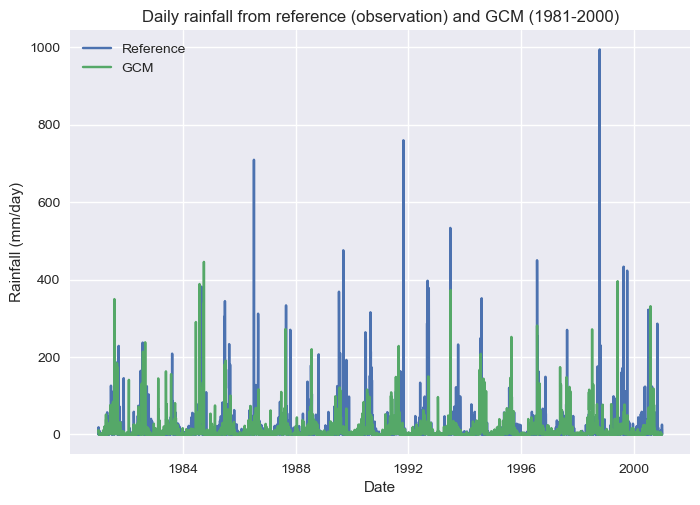

In [252]:
ds=ds.convert_calendar('gregorian', align_on='year',missing=0)
ref=ref.convert_calendar('gregorian', align_on='year',missing=0)

plt.figure
ax=plt.subplot()
ax.plot(df.date,df.pr, label='Reference')
ax.plot(ds.time,ds, label='GCM')
plt.ylabel('Rainfall (mm/day)')
plt.xlabel('Date')
plt.title('Daily rainfall from reference (observation) and GCM (1981-2000)')
plt.legend()

## Apply bias correction algorithms
Now observed and climate data is ready for bias correction (BC) {cite}`qm`. Here, three BC methods used, empirical quantile mapping (QM). linear scaling (LS), local intensity scaling (LOCI), deterending quantile mapping (DQ). As following, each of this method are trained on observation and climate data (GCM) and then applied to adjust data.  

In [283]:
ds = sdba.processing.jitter_under_thresh(ds, "0.01 mm d-1")
ref = sdba.processing.jitter_under_thresh(ref, "0.01 mm d-1")

#quantile mapping bias correction
QM_train = sdba.EmpiricalQuantileMapping.train(ref, ds, nquantiles=15, group="time.dayofyear", kind="*")
QM_adjust = QM_train.adjust(ds, extrapolation="constant", interp="linear")

#linear scaling mapping bias correction
LS_train = sdba.Scaling.train(ref, ds, group='time.dayofyear', kind="*")
LS_adjust = LS_train.adjust(ds)

#local intensity scaling bias correction
LOCI_train = sdba.LOCI.train(ref, ds,thresh='1 mm/day', group="time.dayofyear")
LOCI_adjust = LOCI_train.adjust(ds, interp="linear")

#deternding quantile mapping
QD = sdba.DetrendedQuantileMapping.train(ref, ds, nquantiles=15, group="time.month", kind="*")
QD_adjust = QD.adjust(ds, extrapolation="constant", interp="nearest")


/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xclim/sdba/adjustment.py:118: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xclim/sdba/adjustment.py:118: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xclim/sdba/adjustment.py:118: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/xclim/sdba/adjustment.py:118: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/Users/farid/Abaconda3/anaco

## Evaluating bias corrected data
At this stage, all time sereis data from including reference, GCM, and bias adjusted data are evaluated at daily and monthly time steps. Below shows long term average for each day and month over the historical period, 1981-2000. QM method performs better compared to other methods as can be seen. 

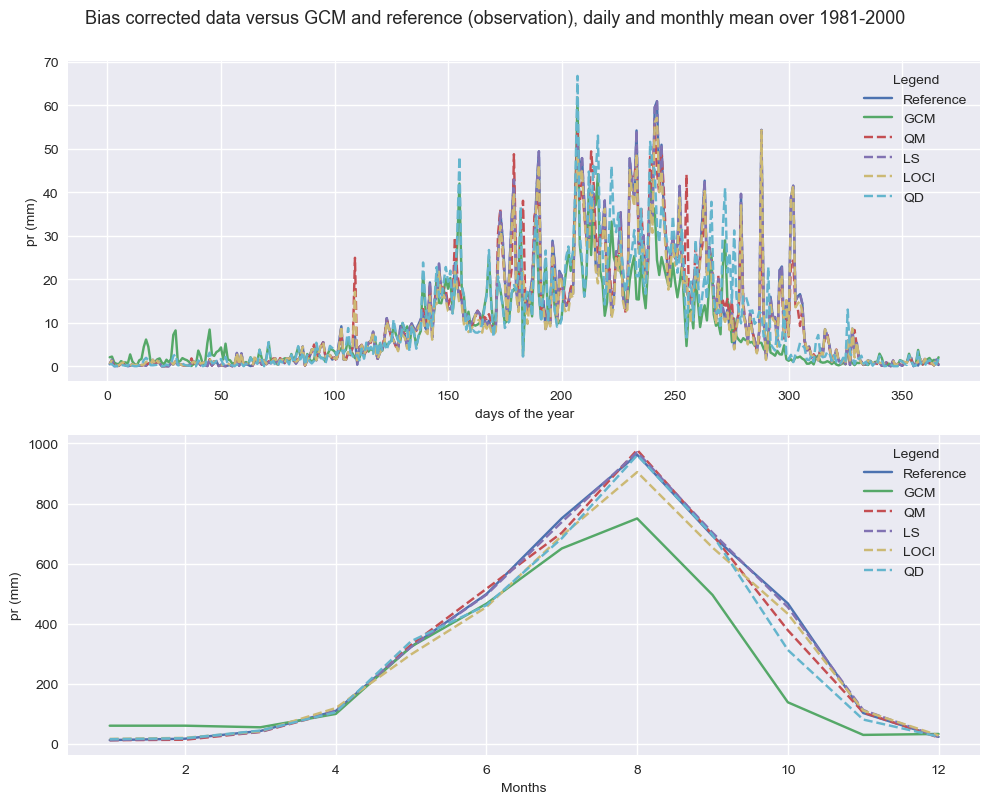

In [254]:
plt.style.use('seaborn')
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
fig, axes = plt.subplots(2,1,figsize=(10,8), tight_layout=True)
fig.suptitle('Bias corrected data versus GCM and reference (observation), daily and monthly mean over 1981-2000',fontsize=13,x=0.5,y=1)

#plot daily average
ref.groupby("time.dayofyear").mean().plot(ax=axes[0], label="Reference")
ds.groupby("time.dayofyear").mean().plot(ax=axes[0], label="GCM")
QM_adjust.groupby("time.dayofyear").mean().plot(ax=axes[0], label="QM", linestyle="--")
LS_adjust.groupby("time.dayofyear").mean().plot(ax=axes[0], label="LS", linestyle="--")
LOCI_adjust.groupby("time.dayofyear").mean().plot(ax=axes[0], label="LOCI", linestyle="--")
QD_adjust.groupby("time.dayofyear").mean().plot(ax=axes[0], label="QD", linestyle="--")
axes[0].set_ylabel('pr (mm)',fontsize=10)
axes[0].set_xlabel('days of the year',fontsize=10)
axes[0].set_title(None)
axes[0].legend(fontsize=10,title='Legend',title_fontsize=10)

#plot monthly average
(ref.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="Reference")
(ds.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="GCM")
(QM_adjust.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="QM", linestyle="--")
(LS_adjust.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="LS", linestyle="--")
(LOCI_adjust.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="LOCI", linestyle="--")
(QD_adjust.groupby("time.month").sum()/len(ds.groupby(ds.time.dt.year))).plot(ax=axes[1], label="QD", linestyle="--")
axes[1].set_xlabel('Months',fontsize=10)
axes[1].set_ylabel('pr (mm)',fontsize=10)
axes[1].set_title(None)
axes[1].legend(fontsize=10,title='Legend',title_fontsize=10)

## Accuracy assessment of bias corrected data


The accuracy of GCM versus observed, bias adjusted versus observed time series is evaluated through performance criteria (Objective function). Coefficient of determination (R2) and Pearson r correlations are used to assess data accuracy. When R2 and Pearson r reach close to 1, two datasets show good correlcation. 


In [223]:
criteria=['Coefficient of Determination (R2)','Pearson r']
def error(o,m):
    x = o.resample(time='1m').sum()
    y = m.resample(time='1m').sum()
    r2 = xs.r2(x,y)
    pearson_r = xs.pearson_r(x,y)
    return np.array([r2,pearson_r])

,GCM,QM,LS,LOCI,QD
Performance criteria,,,,,
Coefficient of Determination (R$^2$),0.30,0.22,0.12,0.23,-0.02
Pearson r,0.60,0.65,0.61,0.61,0.53


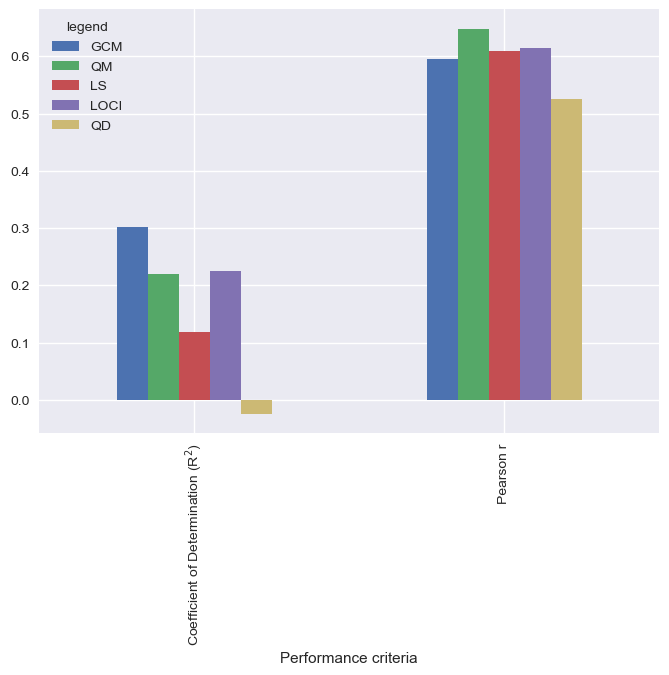

In [284]:
#calculate performance criteria
gcm = error(ref,ds)
qm = error(ref,QM_adjust)
ls = error(ref,LS_adjust)
loci = error(ref,LOCI_adjust)
qd = error(ref,QD_adjust)

#tabulating and plotting data
pd.options.display.float_format = '{:,.2f}'.format
data=pd.DataFrame({'r1':criteria,'GCM':gcm, 'QM':qm, 'LS':ls, 'LOCI':loci,'QD':qd},columns=['GCM','QM','LS','LOCI','QD'],index=criteria).rename_axis('Performance criteria')
data.plot(kind='bar')
plt.legend(title='legend')
data

## References

```{bibliography}
:style: plain
```

In [267]:
QM_mo = sdba.ExtremeValues.train(ref, ds,cluster_thresh='1mm/day')
scen = QM_mo.adjust(ref,ds)


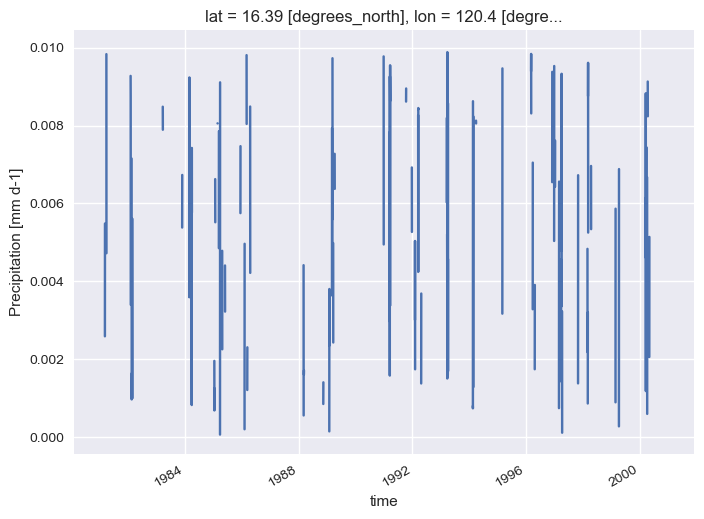

In [280]:
ds.where(ds<0.01).plot()


In [2]:
!pipreqs --force

INFO: Successfully saved requirements file in /Users/farid/Documents/jupyter_book/mybook2/requirements.txt
